In [1]:
import os
import pandas as pd
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms

In [2]:
class CelebADataset(Dataset):
    def __init__(self, root_dir, attr_path, partition_path,
                 split="train", image_size=256, selected_attrs=None):
        self.root_dir = root_dir
        self.attr_path = attr_path
        self.partition_path = partition_path
        self.split = split
        self.image_size = image_size
        self.selected_attrs = selected_attrs

        # Load partition info
        partition_df = pd.read_csv(partition_path)
        partition_df.columns = ["image_id", "partition"]

        split_map = {"train": 0, "val": 1, "test": 2}
        split_ids = partition_df[partition_df["partition"] == split_map[split]]["image_id"].tolist()

        # Load attributes
        attr_df = pd.read_csv(attr_path)
        attr_df.rename(columns={"image_id": "image_id"}, inplace=True)

        # Keep only split images
        self.data = attr_df[attr_df["image_id"].isin(split_ids)].reset_index(drop=True)

        # If selecting subset of attributes
        if self.selected_attrs is not None:
            self.data = self.data[["image_id"] + self.selected_attrs]

        # Transformations
        self.transform = transforms.Compose([
            transforms.Resize((image_size, image_size)),
            transforms.ToTensor(),
            transforms.Normalize([0.5]*3, [0.5]*3)  # Scale to [-1, 1]
        ])

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        img_path = os.path.join(self.root_dir, row["image_id"])
        image = Image.open(img_path).convert("RGB")
        image = self.transform(image)
    
        if self.selected_attrs is not None:
            attrs = row[self.selected_attrs].values.astype("float32")
            attrs = torch.tensor(attrs)
        else:
            # use all attributes if none selected
            attrs = row.drop("image_id").values.astype("float32")
            attrs = torch.tensor(attrs)
    
        # Map -1 → 0 for CelebA binary attrs
        attrs = (attrs == 1).to(torch.float32)
    
        return image, attrs



In [3]:
# Paths (update based on your dataset folder name in /kaggle/input)
root_dir = "/kaggle/input/celeba-dataset/img_align_celeba/img_align_celeba"
attr_path = "/kaggle/input/celeba-dataset/list_attr_celeba.csv"
partition_path = "/kaggle/input/celeba-dataset/list_eval_partition.csv"

# Choose a few attributes to experiment with (later we can expand)
selected_attrs = ["Smiling", "Male", "Young", "Eyeglasses"]

# Train dataset
train_dataset = CelebADataset(
    root_dir=root_dir,
    attr_path=attr_path,
    partition_path=partition_path,
    split="train",
    image_size=256,
    selected_attrs=None
)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=False, num_workers=2)


# Train dataset
val_dataset = CelebADataset(
    root_dir=root_dir,
    attr_path=attr_path,
    partition_path=partition_path,
    split="val",
    image_size=256,
    selected_attrs=None
)

val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False, num_workers=0)
# Train dataset
test_dataset = CelebADataset(
    root_dir=root_dir,
    attr_path=attr_path,
    partition_path=partition_path,
    split="test",
    image_size=256,
    selected_attrs=None
)

test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=0)
# Quick sanity check
imgs, labels = next(iter(train_loader))
print("Image batch:", imgs.shape)   # (64, 3, 64, 64)
print("Labels batch:", labels.shape)  # (64, len(selected_attrs))


Image batch: torch.Size([16, 3, 256, 256])
Labels batch: torch.Size([16, 40])


In [4]:
import matplotlib.pyplot as plt
import torchvision.utils as vutils

def denormalize(imgs):
    """Convert images from [-1,1] back to [0,1] for visualization."""
    return (imgs + 1) / 2

def show_batch(images, labels=None, selected_attrs=None, nrow=8):
    """
    Visualize a batch of images with optional attribute labels.
    
    Args:
        images (Tensor): Batch of images (B,3,H,W) normalized to [-1,1].
        labels (Tensor): Optional binary attribute labels (B,num_attrs).
        selected_attrs (list): Names of attributes corresponding to labels.
        nrow (int): Number of images per row in the grid.
    """
    images = denormalize(images)

    plt.figure(figsize=(16, 8))
    grid = vutils.make_grid(images, nrow=nrow, padding=2)
    plt.imshow(grid.permute(1, 2, 0).cpu().numpy())
    plt.axis("off")
    plt.show()

    if labels is not None and selected_attrs is not None:
        # Print labels in human-readable form
        for i in range(min(len(labels), nrow)):
            label_str = ", ".join(
                [f"{attr}:{int(val)}" for attr, val in zip(selected_attrs, labels[i].cpu().numpy())]
            )
            print(f"Image {i+1}: {label_str}")


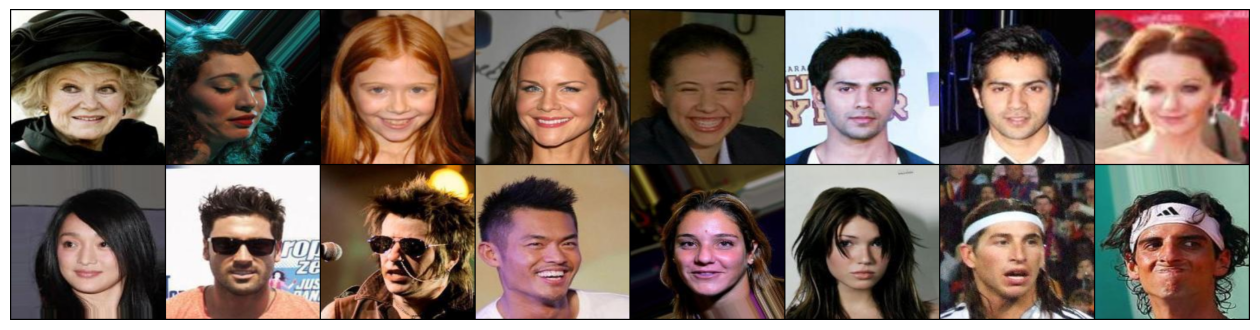

Image 1: Smiling:0, Male:1, Young:0, Eyeglasses:1
Image 2: Smiling:0, Male:0, Young:0, Eyeglasses:0
Image 3: Smiling:0, Male:0, Young:1, Eyeglasses:0
Image 4: Smiling:0, Male:0, Young:1, Eyeglasses:0
Image 5: Smiling:0, Male:0, Young:0, Eyeglasses:0
Image 6: Smiling:1, Male:0, Young:1, Eyeglasses:0
Image 7: Smiling:1, Male:1, Young:0, Eyeglasses:0
Image 8: Smiling:0, Male:0, Young:0, Eyeglasses:0


In [5]:
# Get a batch
imgs, lbls = next(iter(test_loader))

# Show images + attributes
show_batch(imgs, lbls, selected_attrs, nrow=8)


In [6]:
import torch
def plot_attribute_distribution(dataset, selected_attrs):
    """
    Plot distribution (counts of 0 and 1) for each selected attribute.
    
    Args:
        dataset (CelebADataset): Already loaded dataset.
        selected_attrs (list): List of attribute names.
    """
    import seaborn as sns
    
    # Extract labels from dataset dataframe (since it's already preloaded in CelebADataset)
    df = dataset.data[selected_attrs].copy()
    
    # Convert from -1/1 to 0/1 if not already done
    df = (df == 1).astype(int)

    # Plot
    plt.figure(figsize=(14, 6))
    for i, attr in enumerate(selected_attrs, 1):
        plt.subplot(1, len(selected_attrs), i)
        sns.countplot(x=df[attr])
        plt.title(attr)
        plt.xticks([0, 1], ["No", "Yes"])
        plt.xlabel("")
        plt.ylabel("Count")
    plt.tight_layout()
    plt.show()


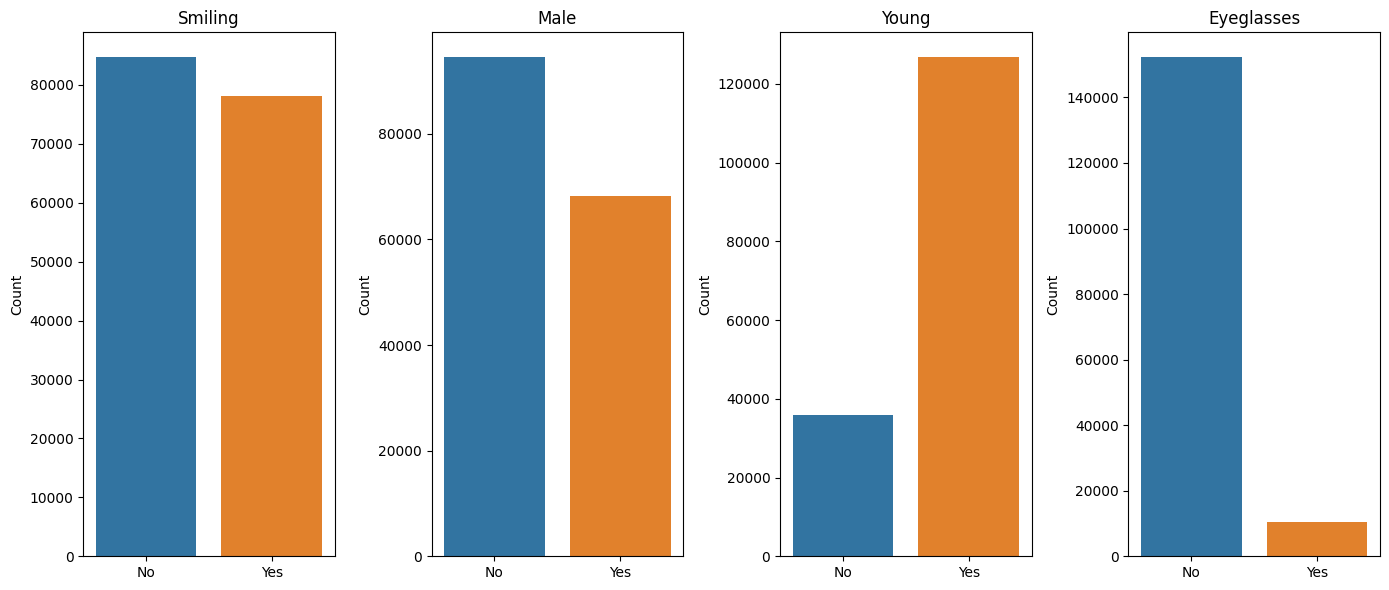

In [7]:
plot_attribute_distribution(train_dataset, selected_attrs)


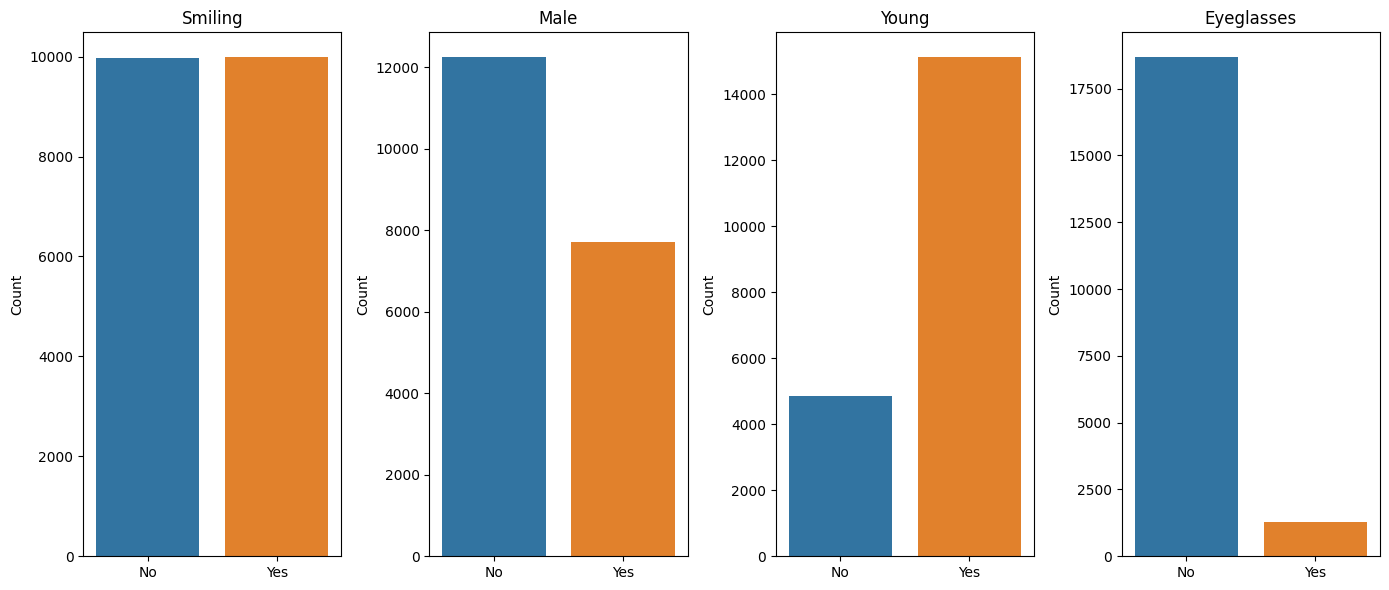

In [8]:
plot_attribute_distribution(test_dataset, selected_attrs)


# VAE

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [10]:
import torch
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm
from diffusers import AutoencoderKL

# -------------------------
# 1. Pre-encode dataset with VAE
# -------------------------
def preencode_with_vae(dataloader, vae, device, save_path="latents.pt"):
    vae.eval()
    all_latents = []
    with torch.no_grad(),torch.autocast("cuda"):
        for imgs, cond in tqdm(dataloader, desc="Encoding dataset with VAE"):
            imgs = imgs.to(device)
            # Encode to latent space (Stable Diffusion convention: scale by 0.18215)
            latents = vae.encode(imgs).latent_dist.mode() * 0.18215
            all_latents.append((latents.cpu(), cond))  # store both latents & cond

    torch.save(all_latents, save_path)
    print(f"✅ Saved {len(all_latents)} batches to {save_path}")





2025-10-13 12:06:18.115073: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1760357178.301061      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1760357178.362103      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [11]:
try:
    vae = AutoencoderKL.from_pretrained(
        "runwayml/stable-diffusion-v1-5", 
        subfolder="vae"
    ).to(device)
    vae.eval()
    print("VAE loaded successfully!")
except:
    print("Error Loading")


config.json:   0%|          | 0.00/547 [00:00<?, ?B/s]

vae/diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

VAE loaded successfully!


In [12]:
# ============================================================
class LatentDataset(Dataset):
    def __init__(self, latent_file):
        super().__init__()
        self.data = torch.load(latent_file)  # list of (latents, cond)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        latents, cond = self.data[idx]
        return latents, cond







In [13]:
import gc
gc.collect()
torch.cuda.empty_cache()

In [ ]:
# Step 1: Encode once
preencode_with_vae(train_loader, vae, device, save_path="train_latents.pt")
preencode_with_vae(val_loader, vae, device, save_path="val_latents.pt")




Encoding dataset with VAE: 100%|██████████| 10174/10174 [1:00:21<00:00,  2.81it/s]


✅ Saved 10174 batches to train_latents.pt


Encoding dataset with VAE:  33%|███▎      | 404/1242 [03:37<07:25,  1.88it/s]

# Diffusion Model

In [15]:
import torch
from torch.utils.data import Dataset

class LatentCelebADataset(Dataset):
    def __init__(self, latents_path):
        """
        latents_path: path to train_latents.pt or val_latents.pt
        Each element in the file is a tuple (latents_batch, cond_batch)
        """
        all_data = torch.load(latents_path)
        self.latents_list, self.attrs_list = [], []

        for latents, cond in all_data:
            for i in range(latents.shape[0]):
                self.latents_list.append(latents[i])  # [C, H, W]
                self.attrs_list.append(cond[i])       # [num_attrs]

    def __len__(self):
        return len(self.latents_list)

    def __getitem__(self, idx):
        latent = self.latents_list[idx]           # [C, H, W]
        attrs = self.attrs_list[idx]              # [num_attrs]
        attrs = (attrs == 1).float()             # Map -1 → 0
        return latent, attrs


In [16]:
class NoiseScheduler:
    def __init__(self, timesteps=1000, beta_start=1e-4, beta_end=0.02, device="cuda"):
        self.timesteps = timesteps
        self.device = device
        self.betas = torch.linspace(beta_start, beta_end, timesteps).to(device)
        self.alphas = 1.0 - self.betas
        self.alpha_cumprod = torch.cumprod(self.alphas, dim=0)

    def add_noise(self, latents, t):
        noise = torch.randn_like(latents)
        sqrt_alpha = self.alpha_cumprod[t].sqrt().view(-1, 1, 1, 1)
        sqrt_one_minus_alpha = (1 - self.alpha_cumprod[t]).sqrt().view(-1, 1, 1, 1)
        return sqrt_alpha * latents + sqrt_one_minus_alpha * noise, noise


In [17]:
import torch.nn as nn
import torch

class TimeEmbedding(nn.Module):
    def __init__(self, dim=256):
        super().__init__()
        self.dim = dim

    def forward(self, t):
        half_dim = self.dim // 2
        emb = torch.log(torch.tensor(10000.0)) / (half_dim - 1)
        emb = torch.exp(torch.arange(half_dim, device=t.device) * -emb)
        emb = t[:, None].float() * emb[None, :]
        emb = torch.cat([torch.sin(emb), torch.cos(emb)], dim=-1)
        return emb

In [18]:
class ConditionalEmbedding(nn.Module):
    def __init__(self, num_attrs=40, cond_dim=256):
        super().__init__()
        # Each attribute has its own embedding vector of size cond_dim
        self.attr_embeddings = nn.Linear(1, cond_dim)

    def forward(self, attrs):
        """
        attrs: [B, num_attrs] binary vector
        returns: [B, num_attrs, cond_dim]
        """
        # Add a last dim for linear layer input
        x = attrs.unsqueeze(-1)          # [B, 40, 1]
        cond_emb = self.attr_embeddings(x)  # [B, 40, cond_dim]
        return cond_emb


In [19]:
class CrossAttention(nn.Module):
    def __init__(self, dim, cond_dim, num_heads=4):
        super().__init__()
        self.num_heads = num_heads
        self.dim = dim
        self.scale = (dim // num_heads) ** -0.5

        self.to_q = nn.Linear(dim, dim, bias=False)
        self.to_k = nn.Linear(cond_dim, dim, bias=False)
        self.to_v = nn.Linear(cond_dim, dim, bias=False)
        self.to_out = nn.Linear(dim, dim)

    def forward(self, x, cond_emb):
        B, N, D = x.shape
        q = self.to_q(x)
        k = self.to_k(cond_emb)
        v = self.to_v(cond_emb)

        q = q.view(B, N, self.num_heads, D // self.num_heads).transpose(1, 2)
        k = k.view(B, -1, self.num_heads, D // self.num_heads).transpose(1, 2)
        v = v.view(B, -1, self.num_heads, D // self.num_heads).transpose(1, 2)

        attn = torch.matmul(q, k.transpose(-2, -1)) * self.scale
        attn = torch.softmax(attn, dim=-1)
        out = torch.matmul(attn, v)
        out = out.transpose(1, 2).contiguous().view(B, N, D)
        return self.to_out(out)


In [20]:
class ResBlock(nn.Module):
    def __init__(self, in_ch, out_ch, time_dim=None, cond_dim=None, use_attention=False):
        super().__init__()
        self.use_attention = use_attention
        self.in_ch, self.out_ch = in_ch, out_ch

        # InstanceNorm works for small latent channels
        self.norm1 = nn.InstanceNorm2d(in_ch, affine=True)
        self.conv1 = nn.Conv2d(in_ch, out_ch, 3, padding=1)
        self.norm2 = nn.InstanceNorm2d(out_ch, affine=True)
        self.conv2 = nn.Conv2d(out_ch, out_ch, 3, padding=1)

        self.shortcut = nn.Conv2d(in_ch, out_ch, 1) if in_ch != out_ch else nn.Identity()
        self.time_mlp = nn.Linear(time_dim, out_ch) if time_dim is not None else None
        self.cross_attn = CrossAttention(out_ch, cond_dim) if cond_dim is not None and use_attention else None
        self.act = nn.ReLU()

    def forward(self, x, t_emb=None, cond_emb=None):
        h = self.act(self.norm1(x))
        h = self.conv1(h)
        if self.time_mlp is not None and t_emb is not None:
            time_out = self.time_mlp(t_emb).unsqueeze(-1).unsqueeze(-1)
            h = h + time_out
        h = self.act(self.norm2(h))
        h = self.conv2(h)
        if self.cross_attn is not None and cond_emb is not None:
            B, C, H, W = h.shape
            h_flat = h.flatten(2).transpose(1, 2)
            h_attn = self.cross_attn(h_flat, cond_emb)
            h = h_attn.transpose(1, 2).view(B, C, H, W)
        return self.act(h + self.shortcut(x))


In [21]:
class LatentDiffusionUNet(nn.Module):
    def __init__(self, latent_dim=4, time_dim=256, cond_dim=256, base_ch=64):
        super().__init__()
        self.latent_dim = latent_dim   # ✅ store it
        self.inc = ResBlock(latent_dim, base_ch, time_dim, cond_dim, use_attention=True)
        self.down1 = ResBlock(base_ch, base_ch*2, time_dim, cond_dim)
        self.down2 = ResBlock(base_ch*2, base_ch*4, time_dim, cond_dim, use_attention=True)
        self.mid = ResBlock(base_ch*4, base_ch*4, time_dim, cond_dim, use_attention=True)
        self.up2 = ResBlock(base_ch*8, base_ch*2, time_dim, cond_dim)
        self.up1 = ResBlock(base_ch*4, base_ch, time_dim, cond_dim)
        self.outc = nn.Conv2d(base_ch, latent_dim, 1)

    def forward(self, x, t_emb, cond_emb):
        h1 = self.inc(x, t_emb, cond_emb)      # base_ch
        h2 = self.down1(h1, t_emb, cond_emb)   # base_ch*2
        h3 = self.down2(h2, t_emb, cond_emb)   # base_ch*4
        h_mid = self.mid(h3, t_emb, cond_emb)  # base_ch*4
    
        # Upsample + skip connections
        h = torch.cat([h_mid, h3], dim=1)      # base_ch*4 + base_ch*4 = base_ch*8
        h = self.up2(h, t_emb, cond_emb)       # output: base_ch*2
    
        h = torch.cat([h, h2], dim=1)          # base_ch*2 + base_ch*2 = base_ch*4
        h = self.up1(h, t_emb, cond_emb)       # output: base_ch
    
        h = torch.cat([h, h1], dim=1)          # base_ch + base_ch = base_ch*2
        # adjust outc to match this channel count:
        final_conv = nn.Conv2d(h.shape[1], self.latent_dim, 1).to(x.device)
        return final_conv(h)



In [22]:
from torch.utils.data import DataLoader
from tqdm.notebook import tqdm
import torch

def train_one_epoch(model, dataloader, optimizer, scheduler, time_emb_model, cond_emb_model, device="cuda"):
    model.train()
    running_loss = 0
    loop = tqdm(dataloader, desc="Training", leave=False)
    
    for latents, attrs in loop:
        latents = latents.to(device)  # [B, C, H, W]
        attrs = attrs.to(device)      # [B, 40]

        # Random timesteps
        t = torch.randint(0, scheduler.timesteps, (latents.size(0),), device=device)
        noisy_latents, noise = scheduler.add_noise(latents, t)

        # Embeddings
        t_emb = time_emb_model(t)     # [B, time_dim]
        c_emb = cond_emb_model(attrs) # [B, 40, cond_dim]

        # Forward
        pred_noise = model(noisy_latents, t_emb, c_emb)

        # Loss
        loss = ((pred_noise - noise)**2).mean()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * latents.size(0)
        loop.set_postfix({"batch_loss": loss.item()})

    return running_loss / len(dataloader.dataset)




In [23]:
import os

def train_diffusion(model, train_dataset, val_dataset=None, epochs=50, batch_size=16, lr=1e-4, device="cuda", save_dir="checkpoints", save_every=10):
    os.makedirs(save_dir, exist_ok=True)
    print("----------Start Training---------")
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False) if val_dataset else None

    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    scheduler = NoiseScheduler(device=device)
    time_emb_model = TimeEmbedding(256).to(device)
    cond_emb_model = ConditionalEmbedding(num_attrs=40, cond_dim=256).to(device)

    best_val_loss = float("inf")

    for epoch in range(1, epochs+1):
        print(f"\nEpoch [{epoch}/{epochs}]")
        train_loss = train_one_epoch(model, train_loader, optimizer, scheduler, time_emb_model, cond_emb_model, device)
        print(f"Train Loss: {train_loss:.6f}")

        val_loss = None
        if val_loader:
            model.eval()
            val_loss = 0
            with torch.no_grad():
                loop = tqdm(val_loader, desc="Validation", leave=False)
                for latents, attrs in loop:
                    latents = latents.to(device)
                    attrs = attrs.to(device)
                    t = torch.randint(0, scheduler.timesteps, (latents.size(0),), device=device)
                    noisy_latents, noise = scheduler.add_noise(latents, t)
                    t_emb = time_emb_model(t)
                    c_emb = cond_emb_model(attrs)
                    pred_noise = model(noisy_latents, t_emb, c_emb)
                    batch_loss = ((pred_noise - noise)**2).mean()
                    val_loss += batch_loss.item() * latents.size(0)
                    loop.set_postfix({"batch_loss": batch_loss.item()})
            val_loss /= len(val_loader.dataset)
            print(f"Validation Loss: {val_loss:.6f}")

        # Save best model based on validation loss
        if val_loss is not None and val_loss < best_val_loss:
            best_val_loss = val_loss
            save_path = os.path.join(save_dir, "best_model.pt")
            torch.save({
                "epoch": epoch,
                "model_state_dict": model.state_dict(),
                "optimizer_state_dict": optimizer.state_dict(),
                "val_loss": best_val_loss
            }, save_path)
            print(f"✅ Saved BEST model at epoch {epoch} with val loss {best_val_loss:.6f}")

        # Optional: save checkpoint every `save_every` epochs
        if epoch % save_every == 0:
            save_path = os.path.join(save_dir, f"checkpoint_epoch_{epoch}.pt")
            torch.save({
                "epoch": epoch,
                "model_state_dict": model.state_dict(),
                "optimizer_state_dict": optimizer.state_dict(),
                "val_loss": val_loss
            }, save_path)
            print(f"💾 Saved checkpoint at epoch {epoch}")


In [24]:
train_dataset = LatentCelebADataset("train_latents.pt")
val_dataset = LatentCelebADataset("val_latents.pt")


In [25]:
import gc
gc.collect()
torch.cuda.empty_cache()

In [ ]:

device = "cuda"
model = LatentDiffusionUNet(latent_dim=4).to(device)

train_diffusion(model, train_dataset, val_dataset, epochs=100, batch_size=64, device=device)


----------Start Training---------

Epoch [1/100]


Training:   0%|          | 0/2544 [00:00<?, ?it/s]

Train Loss: 1.007400


Validation:   0%|          | 0/311 [00:00<?, ?it/s]

Validation Loss: 1.002757
✅ Saved BEST model at epoch 1 with val loss 1.002757

Epoch [2/100]


Training:   0%|          | 0/2544 [00:00<?, ?it/s]

Train Loss: 1.002817


Validation:   0%|          | 0/311 [00:00<?, ?it/s]

Validation Loss: 1.002764

Epoch [3/100]


Training:   0%|          | 0/2544 [00:00<?, ?it/s]

Train Loss: 1.002686


Validation:   0%|          | 0/311 [00:00<?, ?it/s]

Validation Loss: 1.002321
✅ Saved BEST model at epoch 3 with val loss 1.002321

Epoch [4/100]


Training:   0%|          | 0/2544 [00:00<?, ?it/s]

Train Loss: 1.002625


Validation:   0%|          | 0/311 [00:00<?, ?it/s]

Validation Loss: 1.002722

Epoch [5/100]


Training:   0%|          | 0/2544 [00:00<?, ?it/s]

Train Loss: 1.002640


Validation:   0%|          | 0/311 [00:00<?, ?it/s]

Validation Loss: 1.002897

Epoch [6/100]


Training:   0%|          | 0/2544 [00:00<?, ?it/s]

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def plot_cross_attention(save_path="cross_attention.png"):
    fig, ax = plt.subplots(figsize=(8, 4))
    ax.set_xlim(0, 10)
    ax.set_ylim(0, 5)
    ax.axis('off')

    # Boxes
    ax.add_patch(patches.Rectangle((1, 3), 2, 1, edgecolor='black', facecolor='lightblue'))
    ax.text(2, 3.5, "Query\n(latent features)", ha='center', va='center')

    ax.add_patch(patches.Rectangle((1, 1), 2, 1, edgecolor='black', facecolor='lightgreen'))
    ax.text(2, 1.5, "Keys/Values\n(conditional)", ha='center', va='center')

    ax.add_patch(patches.Rectangle((7, 2), 2, 1, edgecolor='black', facecolor='salmon'))
    ax.text(8, 2.5, "Output\n(attended features)", ha='center', va='center')

    # Arrows
    ax.annotate("", xy=(7, 2.5), xytext=(3, 3.5), arrowprops=dict(arrowstyle="->"))
    ax.annotate("", xy=(7, 2.5), xytext=(3, 1.5), arrowprops=dict(arrowstyle="->"))

    plt.savefig(save_path, bbox_inches='tight')
    plt.show()

plot_cross_attention()


In [ ]:
def plot_resblock(save_path="resblock.png"):
    fig, ax = plt.subplots(figsize=(8, 4))
    ax.axis('off')

    # Boxes
    layers = ["Input", "InstanceNorm + ReLU", "Conv1", "Time Embedding\n(optional)", "Conv2", "CrossAttention\n(optional)", "Residual\nConnection", "Output"]
    y = 8
    for layer in layers:
        ax.add_patch(patches.Rectangle((2, y), 6, 0.8, edgecolor='black', facecolor='lightblue'))
        ax.text(5, y+0.4, layer, ha='center', va='center')
        y -= 1.2

    # Arrows
    y_arrow = 8.4
    for _ in layers[:-1]:
        ax.annotate("", xy=(5, y_arrow-1.2), xytext=(5, y_arrow), arrowprops=dict(arrowstyle="->"))
        y_arrow -= 1.2

    plt.savefig(save_path, bbox_inches='tight')
    plt.show()

plot_resblock()


In [ ]:
def plot_unet(save_path="unet.png"):
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.axis('off')

    # Encoder
    encoder_boxes = ["Latent Input", "Inc + Attention", "Down1", "Down2 + Attention"]
    y = 5
    for box in encoder_boxes:
        ax.add_patch(patches.Rectangle((0, y), 2, 1, edgecolor='black', facecolor='lightblue'))
        ax.text(1, y+0.5, box, ha='center', va='center')
        y -= 1.5

    # Bottleneck
    ax.add_patch(patches.Rectangle((4, 2), 2, 1, edgecolor='black', facecolor='salmon'))
    ax.text(5, 2.5, "Bottleneck + Attention", ha='center', va='center')

    # Decoder
    decoder_boxes = ["Up2", "Up1", "Output"]
    y = 3.5
    for i, box in enumerate(decoder_boxes):
        ax.add_patch(patches.Rectangle((7, y - i*1.5), 2, 1, edgecolor='black', facecolor='lightgreen'))
        ax.text(8, y - i*1.5 +0.5, box, ha='center', va='center')

    # Skip connections
    ax.annotate("", xy=(2, 4.5), xytext=(7, 4), arrowprops=dict(arrowstyle="->", color='red', lw=2))
    ax.annotate("", xy=(2, 3), xytext=(7, 2.5), arrowprops=dict(arrowstyle="->", color='red', lw=2))

    plt.savefig(save_path, bbox_inches='tight')
    plt.show()

plot_unet()


In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# ------------------------------
# Cross-Attention Diagram
# ------------------------------
def plot_cross_attention(save_path="cross_attention.png"):
    fig, ax = plt.subplots(figsize=(10, 5), dpi=300)
    ax.set_xlim(0, 10)
    ax.set_ylim(0, 5)
    ax.axis('off')

    # Boxes
    ax.add_patch(patches.Rectangle((1, 3), 2, 1, edgecolor='black', facecolor='lightblue'))
    ax.text(2, 3.5, "Query\n(latent features)", ha='center', va='center', fontsize=10)

    ax.add_patch(patches.Rectangle((1, 1), 2, 1, edgecolor='black', facecolor='lightgreen'))
    ax.text(2, 1.5, "Keys/Values\n(conditional)", ha='center', va='center', fontsize=10)

    ax.add_patch(patches.Rectangle((7, 2), 2, 1, edgecolor='black', facecolor='salmon'))
    ax.text(8, 2.5, "Output\n(attended features)", ha='center', va='center', fontsize=10)

    # Arrows
    ax.annotate("", xy=(7, 2.5), xytext=(3, 3.5), arrowprops=dict(arrowstyle="->", lw=2))
    ax.annotate("", xy=(7, 2.5), xytext=(3, 1.5), arrowprops=dict(arrowstyle="->", lw=2))

    plt.savefig(save_path, bbox_inches='tight', dpi=300)
    plt.close()

# ------------------------------
# ResBlock Diagram
# ------------------------------
def plot_resblock(save_path="resblock.png"):
    fig, ax = plt.subplots(figsize=(10, 3), dpi=300)
    ax.axis('off')

    x_positions = [0, 2, 4, 6, 8]
    labels = ["Input", "Conv1 + ReLU", "Time Embedding\n(optional)", "Conv2", "CrossAttention\n(optional)\n+ Residual"]

    for x, label in zip(x_positions, labels):
        ax.add_patch(patches.Rectangle((x, 1), 1.5, 1, edgecolor='black', facecolor='lightblue'))
        ax.text(x + 0.75, 1.5, label, ha='center', va='center', fontsize=10)

    # Arrows
    for x in x_positions[:-1]:
        ax.annotate("", xy=(x+1.5, 1.5), xytext=(x+1.6, 1.5), arrowprops=dict(arrowstyle="->", lw=2))

    plt.savefig(save_path, bbox_inches='tight', dpi=300)
    plt.close()


# ------------------------------
# Latent UNet Diagram
# ------------------------------
def plot_unet(save_path="unet.png"):
    fig, ax = plt.subplots(figsize=(12, 5), dpi=300)
    ax.axis('off')

    # Encoder
    encoder_boxes = ["Latent Input", "Inc + Attention", "Down1", "Down2 + Attention"]
    x = 0
    for box in encoder_boxes:
        ax.add_patch(patches.Rectangle((x, 2), 1.5, 1, edgecolor='black', facecolor='lightblue'))
        ax.text(x+0.75, 2.5, box, ha='center', va='center', fontsize=10)
        x += 2

    # Bottleneck
    ax.add_patch(patches.Rectangle((x, 2), 2, 1, edgecolor='black', facecolor='salmon'))
    ax.text(x+1, 2.5, "Bottleneck + Attention", ha='center', va='center', fontsize=10)
    bottleneck_x = x
    x += 3

    # Decoder
    decoder_boxes = ["Up2", "Up1", "Output"]
    y_positions = [2, 2, 2]
    for i, box in enumerate(decoder_boxes):
        ax.add_patch(patches.Rectangle((x, y_positions[i]), 2, 1, edgecolor='black', facecolor='lightgreen'))
        ax.text(x+1, y_positions[i]+0.5, box, ha='center', va='center', fontsize=10)
        x += 3

    # Skip connections (arrows from encoder to decoder)
    ax.annotate("", xy=(3, 3), xytext=(9, 3), arrowprops=dict(arrowstyle="->", color='red', lw=2))
    ax.annotate("", xy=(5, 3), xytext=(12, 3), arrowprops=dict(arrowstyle="->", color='red', lw=2))

    plt.savefig(save_path, bbox_inches='tight', dpi=300)
    plt.close()


# ------------------------------
# Generate all images
# ------------------------------
plot_cross_attention()
plot_resblock()
plot_unet()
print("All architecture diagrams saved in high resolution (300 DPI).")


In [ ]:
from graphviz import Digraph

def resblock_diagram(save_path="resblock_highres"):
    dot = Digraph(format='png')
    dot.attr(rankdir='LR', size='12,4', dpi='600')  # high resolution

    # Style
    style_box = {'style': 'rounded,filled', 'fontsize': '12', 'fontname':'Helvetica'}

    # Nodes
    dot.node('input', 'Input', fillcolor='lightgrey', **style_box)
    dot.node('norm1', 'InstanceNorm + ReLU', fillcolor='lightblue', **style_box)
    dot.node('conv1', 'Conv1', fillcolor='skyblue', **style_box)
    dot.node('time', 'Time Embedding\n(optional)', fillcolor='lightgreen', **style_box)
    dot.node('norm2', 'InstanceNorm + ReLU', fillcolor='lightblue', **style_box)
    dot.node('conv2', 'Conv2', fillcolor='skyblue', **style_box)
    dot.node('attn', 'CrossAttention\n(optional)', fillcolor='salmon', **style_box)
    dot.node('res', 'Residual Add', fillcolor='orange', **style_box)
    dot.node('output', 'Output', fillcolor='lightgrey', **style_box)

    # Edges
    edges = [('input', 'norm1'), ('norm1', 'conv1'), ('conv1', 'time'),
             ('time', 'norm2'), ('norm2', 'conv2'), ('conv2', 'attn'), ('attn', 'res'), ('res', 'output')]
    for e in edges:
        dot.edge(*e, arrowsize='1.0', color='black')

    dot.edge('input', 'res', style='dashed', color='red', arrowsize='1.0')  # residual

    dot.render(save_path, cleanup=True)
    print(f"ResBlock diagram saved as {save_path}.png (high resolution)")

resblock_diagram()


In [ ]:
def unet_diagram(save_path="unet_highres"):
    dot = Digraph(format='png')
    dot.attr(rankdir='LR', size='15,6', dpi='600')  # high resolution

    style_box = {'style': 'rounded,filled', 'fontsize': '12', 'fontname':'Helvetica'}

    # Encoder
    dot.node('input', 'Latent Input', fillcolor='lightgrey', **style_box)
    dot.node('inc', 'Inc + Attention', fillcolor='lightblue', **style_box)
    dot.node('down1', 'Down1', fillcolor='skyblue', **style_box)
    dot.node('down2', 'Down2 + Attention', fillcolor='lightgreen', **style_box)

    # Bottleneck
    dot.node('bottleneck', 'Bottleneck + Attention', fillcolor='salmon', **style_box)

    # Decoder
    dot.node('up2', 'Up2', fillcolor='lightgreen', **style_box)
    dot.node('up1', 'Up1', fillcolor='skyblue', **style_box)
    dot.node('output', 'Output', fillcolor='lightgrey', **style_box)

    # Encoder connections
    dot.edge('input', 'inc', arrowsize='1.2')
    dot.edge('inc', 'down1', arrowsize='1.2')
    dot.edge('down1', 'down2', arrowsize='1.2')
    dot.edge('down2', 'bottleneck', arrowsize='1.2')

    # Decoder connections
    dot.edge('bottleneck', 'up2', arrowsize='1.2')
    dot.edge('up2', 'up1', arrowsize='1.2')
    dot.edge('up1', 'output', arrowsize='1.2')

    # Skip connections
    dot.edge('down2', 'up2', style='dashed', color='red', arrowsize='1.0')
    dot.edge('down1', 'up1', style='dashed', color='red', arrowsize='1.0')
    dot.edge('inc', 'output', style='dashed', color='red', arrowsize='1.0')

    dot.render(save_path, cleanup=True)
    print(f"UNet diagram saved as {save_path}.png (high resolution)")

unet_diagram()


In [ ]:
from graphviz import Digraph
import os
def conditional_diffusion_pipeline(save_path="conditional_diffusion_pipeline"):
    dot = Digraph(format='png')
    dot.attr(rankdir='LR', size='18,6', dpi='600')  # high-res
    style_box = {'style': 'rounded,filled', 'fontsize': '12', 'fontname':'Helvetica'}

    # Input and noise
    dot.node('input', 'Input Image', fillcolor='lightgrey', **style_box)
    dot.node('noise', 'Add Noise', fillcolor='lightyellow', **style_box)

    # UNet Encoder
    dot.node('inc', 'Inc + Attention (ResBlock)', fillcolor='lightblue', **style_box)
    dot.node('down1', 'Down1 (ResBlock)', fillcolor='skyblue', **style_box)
    dot.node('down2', 'Down2 + Attention (ResBlock)', fillcolor='lightgreen', **style_box)

    # Bottleneck
    dot.node('bottleneck', 'Bottleneck + Attention (ResBlock)', fillcolor='salmon', **style_box)

    # UNet Decoder
    dot.node('up2', 'Up2 (ResBlock)', fillcolor='lightgreen', **style_box)
    dot.node('up1', 'Up1 (ResBlock)', fillcolor='skyblue', **style_box)
    dot.node('output', 'Output Image / Predicted Noise', fillcolor='lightgrey', **style_box)

    # Forward flow
    dot.edge('input', 'noise', arrowsize='1.2')
    dot.edge('noise', 'inc', arrowsize='1.2')
    dot.edge('inc', 'down1', arrowsize='1.2')
    dot.edge('down1', 'down2', arrowsize='1.2')
    dot.edge('down2', 'bottleneck', arrowsize='1.2')
    dot.edge('bottleneck', 'up2', arrowsize='1.2')
    dot.edge('up2', 'up1', arrowsize='1.2')
    dot.edge('up1', 'output', arrowsize='1.2')

    # Skip connections
    dot.edge('down2', 'up2', style='dashed', color='red', arrowsize='1.0')
    dot.edge('down1', 'up1', style='dashed', color='red', arrowsize='1.0')
    dot.edge('inc', 'output', style='dashed', color='red', arrowsize='1.0')

    dot.render(save_path, cleanup=True)
    print(f"Conditional Diffusion Pipeline saved as {save_path}.png (high resolution)")

conditional_diffusion_pipeline()


In [ ]:
from graphviz import Digraph
image_folder = "images"
def save_resblock(image_folder):
    path = os.path.join(image_folder, "resblock.png")
    dot = Digraph(format='png')
    dot.attr(rankdir='LR', size='12,4', dpi='600')
    style_box = {'style': 'rounded,filled', 'fontsize': '10', 'fontname':'Helvetica'}

    # Nodes
    dot.node('input', 'Input', fillcolor='lightgrey', **style_box)
    dot.node('norm1', 'InstanceNorm + ReLU', fillcolor='lightblue', **style_box)
    dot.node('conv1', 'Conv1', fillcolor='skyblue', **style_box)
    dot.node('time', 'Time Embedding\n(optional)', fillcolor='lightgreen', **style_box)
    dot.node('norm2', 'InstanceNorm + ReLU', fillcolor='lightblue', **style_box)
    dot.node('conv2', 'Conv2', fillcolor='skyblue', **style_box)
    dot.node('attn', 'CrossAttention\n(optional)', fillcolor='salmon', **style_box)
    dot.node('res', 'Residual Add', fillcolor='orange', **style_box)
    dot.node('output', 'Output', fillcolor='lightgrey', **style_box)

    # Edges
    edges = [('input','norm1'), ('norm1','conv1'), ('conv1','time'), ('time','norm2'),
             ('norm2','conv2'), ('conv2','attn'), ('attn','res'), ('res','output')]
    for e in edges:
        dot.edge(*e, arrowsize='1.0', color='black')
    dot.edge('input', 'res', style='dashed', color='red')  # residual

    dot.render(path, cleanup=True)
    print(f"Saved {path}")

def save_unet(image_folder):
    path = os.path.join(image_folder, "unet.png")
    dot = Digraph(format='png')
    dot.attr(rankdir='LR', size='15,6', dpi='600')
    style_box = {'style': 'rounded,filled', 'fontsize': '10', 'fontname':'Helvetica'}

    # Encoder
    dot.node('input', 'Latent Input', fillcolor='lightgrey', **style_box)
    dot.node('inc', 'Inc + Attention', fillcolor='lightblue', **style_box)
    dot.node('down1', 'Down1', fillcolor='skyblue', **style_box)
    dot.node('down2', 'Down2 + Attention', fillcolor='lightgreen', **style_box)

    # Bottleneck
    dot.node('bottleneck', 'Bottleneck + Attention', fillcolor='salmon', **style_box)

    # Decoder
    dot.node('up2', 'Up2', fillcolor='lightgreen', **style_box)
    dot.node('up1', 'Up1', fillcolor='skyblue', **style_box)
    dot.node('output', 'Output Image / Predicted Noise', fillcolor='lightgrey', **style_box)

    # Forward edges
    dot.edge('input','inc')
    dot.edge('inc','down1')
    dot.edge('down1','down2')
    dot.edge('down2','bottleneck')
    dot.edge('bottleneck','up2')
    dot.edge('up2','up1')
    dot.edge('up1','output')

    # Skip connections
    dot.edge('down2','up2', style='dashed', color='red')
    dot.edge('down1','up1', style='dashed', color='red')
    dot.edge('inc','output', style='dashed', color='red')

    dot.render(path, cleanup=True)
    print(f"Saved {path}")

def save_full_pipeline(image_folder):
    path = os.path.join(image_folder, "full_pipeline.png")
    dot = Digraph(format='png')
    dot.attr(rankdir='LR', size='20,8', dpi='600')
    style_box = {'style': 'rounded,filled', 'fontsize': '10', 'fontname':'Helvetica'}

    # Input and noise
    dot.node('input', 'Input Image', fillcolor='lightgrey', **style_box)
    dot.node('noise', 'Add Noise', fillcolor='lightyellow', **style_box)

    # Encoder ResBlocks
    encoder_blocks = {
        'inc': 'Inc (ResBlock)\n- Norm+ReLU\n- Conv1\n- Time Embedding\n- Conv2\n- CrossAttention\n- Residual',
        'down1': 'Down1 (ResBlock)\n- Norm+ReLU\n- Conv1\n- Time Embedding\n- Conv2\n- Residual',
        'down2': 'Down2 (ResBlock+Attention)\n- Norm+ReLU\n- Conv1\n- Time Embedding\n- Conv2\n- CrossAttention\n- Residual'
    }
    colors = {'inc':'lightblue', 'down1':'skyblue', 'down2':'lightgreen'}
    for node,label in encoder_blocks.items():
        dot.node(node, label, fillcolor=colors[node], **style_box)

    # Bottleneck
    dot.node('bottleneck', 'Bottleneck (ResBlock + Attention)\n- Norm+ReLU\n- Conv1\n- Time Embedding\n- Conv2\n- CrossAttention\n- Residual',
             fillcolor='salmon', **style_box)

    # Decoder
    decoder_blocks = {'up2':'Up2 (ResBlock)\n- Norm+ReLU\n- Conv1\n- Time Embedding\n- Conv2\n- Residual',
                      'up1':'Up1 (ResBlock)\n- Norm+ReLU\n- Conv1\n- Time Embedding\n- Conv2\n- Residual'}
    colors_decoder = {'up2':'lightgreen','up1':'skyblue'}
    for node,label in decoder_blocks.items():
        dot.node(node,label,fillcolor=colors_decoder[node], **style_box)

    # Output
    dot.node('output','Output Image / Predicted Noise', fillcolor='lightgrey', **style_box)

    # Forward edges
    dot.edge('input','noise')
    dot.edge('noise','inc')
    dot.edge('inc','down1')
    dot.edge('down1','down2')
    dot.edge('down2','bottleneck')
    dot.edge('bottleneck','up2')
    dot.edge('up2','up1')
    dot.edge('up1','output')

    # Skip connections
    dot.edge('down2','up2', style='dashed', color='red')
    dot.edge('down1','up1', style='dashed', color='red')
    dot.edge('inc','output', style='dashed', color='red')

    dot.render(path, cleanup=True)
    print(f"Saved {path}")

# Save all images
save_resblock(image_folder)
save_unet(image_folder)
save_full_pipeline(image_folder)


In [ ]:
import os
from IPython.display import FileLink

# --- Configuration ---
# The name of the folder inside /kaggle/working/ that contains your graphs
GRAPH_FOLDER = "/kaggle/working/images" 

# The desired name for your final zip file
ZIP_FILENAME = "all_graphs_output.zip"

# Create the directory if it doesn't exist (e.g., if your code hasn't created it yet)
if not os.path.exists(GRAPH_FOLDER):
    os.makedirs(GRAPH_FOLDER)

# Assume your graph saving code (e.g., plt.savefig()) saves files into GRAPH_FOLDER

# --- Execution ---

# 1. Use the shell command to zip the entire folder
# -r: recursive (include all subdirectories/files)
# -q: quiet (suppress output)
print(f"Zipping contents of {GRAPH_FOLDER} into {ZIP_FILENAME}...")
!zip -r -q {ZIP_FILENAME} {GRAPH_FOLDER}

# 2. Verify the zip file was created in the working directory
if os.path.exists(ZIP_FILENAME):
    print("✅ Zip file created successfully.")
    
    # 3. Generate the download link
    # NOTE: The FileLink path must be relative to /kaggle/working/
    print("Click the link below to download:")
    download_link = FileLink(ZIP_FILENAME)
    
    # Display the link
    display(download_link)

else:
    print("❌ Error: Zip file was not created.")